## Roudranil Das

#### Roll: MDS202227

#### Email: [roudranil@cmi.ac.in](mailto:roudranil@cmi.ac.in)


# Setup


In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Some commands to setup the environment


In [ ]:
! pip install sentencepiece
! ln -s /content/drive/MyDrive/nlp-assignments/assignment-1/ assignment-1
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
! apt install cm-super

# Imports


In [ ]:
import numpy as np
import pandas as pd
import sentencepiece as spm
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [ ]:
import gc
from tqdm import tqdm
from time import time
import glob
import os

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
plt.rcParams.update(
    {"figure.figsize": (8, 5), "text.usetex": True, "font.family": "serif"}
)

# Extraction


I took the complete document will the english lines, and I split it into $181$ files, each with roughly $43000$ lines of english words.


In [ ]:
with open("assignment-1/data/wikisent.txt", "r") as f:
    fulltext = f.readlines()

some n documents with 43000 lines in each seems to be a good split


In [ ]:
len(fulltext)  # this many lines are there in total

7818536

In [ ]:
loop = tqdm(range(43000, 7818536, 43000))
for _, i in enumerate(loop):
    loop.set_postfix_str(f"Exporting file {_}")
    subtext = fulltext[i - 43000 : i]
    with open(f"assignment-1/data/english-{_}.txt", "w") as f:
        f.writelines(subtext)
        f.close()

100%|██████████| 181/181 [00:14<00:00, 12.35it/s, Exporting file 180]


# Preprocessing


In [ ]:
def clean_raw_input(filename: str):
    """
    A function to take the filename of the raw input file as input and process the corresponding text file
    preprocessing includes:
    - removing everything except english letters, white space and new line
    - converting upper case letters to lower case

    TODO
    ----
    Convert everything that uses numpy to use pytorch and use gpu to speed up the computation

    Parameters
    ----------
    filename:   str
                Name of the file to be processed

    Output
    ------
    Saves the processed file with the same filename
    """
    with open(f"assignment-1/data/{filename}", "r") as f:
        text = f.read()
    text = text.lower()
    # the next two lines basically converts every char in the string to its unicode code
    text_array = np.array(list(text))
    unicode_array = text_array.view(np.int32)
    del text
    gc.collect()
    # we can use this vector of unicode codes to filter out what we need
    # this makes things faster as we are leveraging numpy's vectorised operations
    cleaned_text_array = text_array[
        (
            np.greater_equal(unicode_array, 97) & np.less_equal(unicode_array, 122)
        )  # lower case letters
        | (np.equal(unicode_array, 32))  # white space
        | (np.equal(unicode_array, 10))  # new line
    ]
    cleaned_text = "".join(cleaned_text_array)
    with open(f"assignment-1/cleaned-data/{filename}", "w") as f:
        f.write(cleaned_text)
        f.close()
    del text_array
    del unicode_array
    del cleaned_text_array
    del cleaned_text
    gc.collect()

In [ ]:
# here i preprocess all the input files
loop = tqdm(os.listdir("assignment-1/data"))
for filename in loop:
    loop.set_postfix_str(f"Parsing file {filename}")
    clean_raw_input(filename)

100%|██████████| 181/181 [09:37<00:00,  3.19s/it, Parsing file english-180.txt]


The next code cell is to train the sentence piece model on the cleaned text documents. I choose `byte-pair` encoding, but I tried with `unigram` as well, and there was not much difference.

Similarly for vocab size, I experimented with sizes of $8, 000$, $16, 000$ and $24, 000$. There was not much difference in either of them so I selected $16, 000$ as it is commonly used.


In [ ]:
spm.SentencePieceTrainer.Train(
    input=glob.glob("assignment-1/cleaned-data/*.txt"),
    input_format="text",
    model_prefix="english-all",
    model_type="bpe",
    vocab_size=16000,
)

True

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load("assignment-1/english-all.model")

True

In [ ]:
# ! cp english-all.model assignment-1/english-all.model
# ! cp english-all.vocab assignment-1/english-all.vocab

In [ ]:
def tokenize(s):
    """
    convenience wrapper to call encode_as_pieces
    """
    return sp.encode_as_pieces(s)

In [ ]:
tokenize("hello world")  # an example of tokenization

['▁hell', 'o', '▁world']

Next I iterate through all the $181$ files, and I tokenize each one of them with the trained `SentencePiece` tokenizer, and I get the frequencies of each of the tokens with `Counter` and save them as a `.tsv` file.


In [ ]:
def tokenize_multiple_files(file_list, )

In [ ]:
files = glob.glob("assignment-1/cleaned-data/*.txt")
loop = tqdm([os.path.basename(_) for _ in files])
for filename in loop:
    loop.set_postfix_str(f"Tokenizing {filename}")
    with open(f"assignment-1/cleaned-data/{filename}", "r") as f:
        text = f.read()
    vocab = Counter(tokenize(text))
    del text
    gc.collect()
    loop.set_postfix_str(f"Tokenizing {filename} done. Saving vocab.")
    with open(f"assignment-1/vocab/{filename[:-4]}.tsv", "w") as f:
        for token, count in vocab.items():
            f.write(f"{token}\t{count}\n")
        f.close()
    del vocab
    gc.collect()

100%|██████████| 181/181 [48:40<00:00, 16.14s/it, Tokenizing english-180.txt done. Saving vocab.]


# Verifying Zipf's Law


To verify Zipf's law across all the documents, I read each of the vocabs saved as a `.tsv` file into a `Counter` object and I add all of them up to get total counts across the entire dataset.


In [ ]:
overall_vocab = Counter()
files = tqdm(glob.glob("assignment-1/vocab/*.tsv"))
for filename in files:
    current_vocab = Counter(
        dict(pd.read_csv(filename, sep="\t", names=["tokens", "counts"]).values)
    )
    overall_vocab += current_vocab

100%|██████████| 181/181 [00:05<00:00, 30.36it/s]


In [ ]:
def plot_zipfs_law(vocab, title):
    """
    Convenience function to plot log-log graph of frequency vs rank based on vocab
    """
    # calculate the types and tokens
    types = len(vocab.keys())
    tokens = sum(vocab.values())
    # get the words in the decreasing order of frequency
    # and their frequencies and ranks
    sorted_words = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
    frequencies = [freq for _, freq in sorted_words]
    ranks = list(range(1, len(frequencies) + 1))

    fig, ax = plt.subplots(1, 1)

    ax.loglog(
        ranks,
        frequencies,
        marker=".",
        linestyle="--",
        color="b",
        markerfacecolor="red",
        label="Observed data points",
    )
    ax.set_xlabel("Rank", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis="both", which="major", direction="in", length=6)
    ax.tick_params(axis="both", which="minor", direction="in", length=3)
    ax.grid(
        visible=True,
        which="major",
        axis="both",
        ls=(0, (3, 5, 1, 5)),
        color="black",
        alpha=0.8,
    )
    ax.tick_params(axis="both", which="major", direction="in", length=6)
    ax.tick_params(axis="both", which="minor", direction="in", length=3)
    line1 = mpl.lines.Line2D([], [], color="white", label=f"Vocabulary count = {types}")
    line2 = mpl.lines.Line2D([], [], color="white", label=f"Token count = {tokens}")
    line3 = mpl.lines.Line2D(
        [], [], color="white", label=f"Type/token ratio = {types/tokens: .2e}"
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles + [line1, line2, line3])
    plt.tight_layout()
    plt.show()

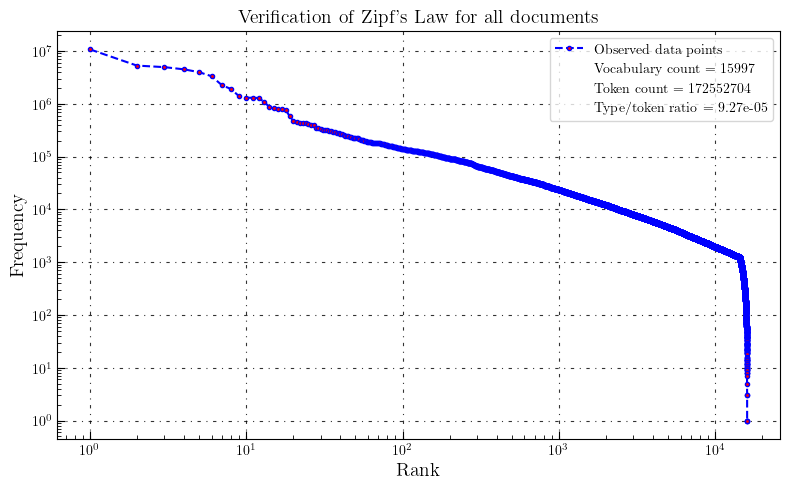

In [ ]:
plot_zipfs_law(overall_vocab, "Verification of Zipf's Law for all documents")

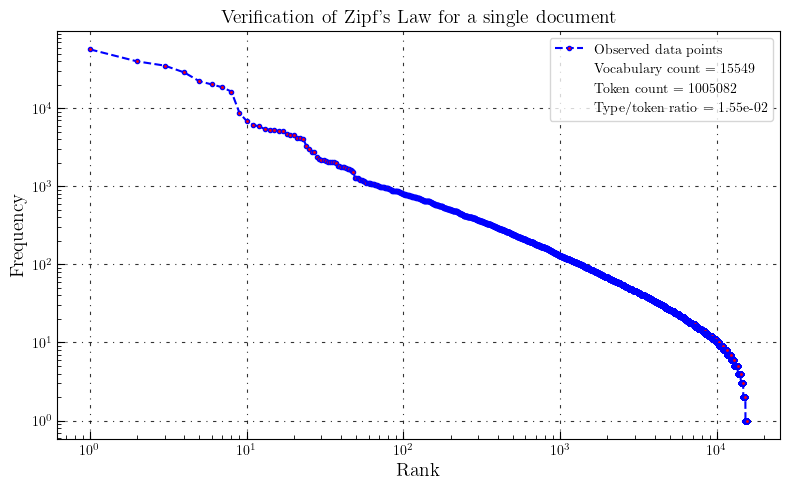

In [ ]:
single_vocab = Counter(
    dict(
        pd.read_csv(
            "assignment-1/vocab/english-0.tsv", sep="\t", names=["tokens", "counts"]
        ).values
    )
)
plot_zipfs_law(single_vocab, "Verification of Zipf's Law for a single document")

# Heap's Law


In order to verify Heap's Law it generally helps to have documents of different sizes. Since we have split the docs in such a way, that all of them are roughly of the same size, we randomly select a subset of each of the files, and retokenize them in order to get ddocuments of varying sizes.


In [ ]:
# randomly selecting some random subset of each file
np.random.seed(42)
sizes = np.random.randint(low=2000, high=43000, size=181)
loop = tqdm(glob.glob("assignment-1/cleaned-data/*.txt"))
for i, file in enumerate(loop):
    loop.set_postfix_str(f"Parsing file {os.path.basename(file)}...")
    with open(file, "r") as f:
        lines = f.readlines()
    subset = np.random.choice(lines, size=sizes[i])
    with open(f"assignment-1/subset-data/{os.path.basename(file)}", "w") as f:
        f.writelines(subset)
        f.close()

100%|██████████| 181/181 [02:35<00:00,  1.17it/s, Parsing file english-180.txt...]


Tokenizing each of the subset files


In [ ]:
files = glob.glob("assignment-1/subset-data/*.txt")
loop = tqdm([os.path.basename(_) for _ in files])
for filename in loop:
    loop.set_postfix_str(f"Tokenizing {filename}")
    with open(f"assignment-1/cleaned-data/{filename}", "r") as f:
        text = f.read()
    vocab = Counter(tokenize(text))
    # vocab = Counter(nltk.tokenize.word_tokenize(text))
    del text
    gc.collect()
    loop.set_postfix_str(f"Tokenizing {filename} done. Saving vocab.")
    with open(f"assignment-1/vocab/{filename[:-4]}.tsv", "w") as f:
        for token, count in vocab.items():
            f.write(f"{token}\t{count}\n")
        f.close()
    del vocab
    gc.collect()

100%|██████████| 181/181 [45:08<00:00, 14.96s/it, Tokenizing english-178.txt done. Saving vocab.]


For fitting the polynomial across a large range of vocab and corpus sizes, we take a cumulative sum of corpus and vocab sizes across all the files.


In [ ]:
files = tqdm(glob.glob("assignment-1/vocab/*.tsv"))
vocab_sizes_list = []
corpus_sizes_list = []
running_vocab = Counter()
for filename in files:
    vocab = Counter(
        dict(pd.read_csv(filename, sep="\t", names=["tokens", "counts"]).values)
    )
    running_vocab += vocab
    del vocab
    gc.collect()
    vocab_sizes_list.append(len(running_vocab.keys()))
    corpus_sizes_list.append(sum(running_vocab.values()))

100%|██████████| 181/181 [00:29<00:00,  6.12it/s]


Then we estimate the coefficients. For computational efficiency we take the first 50 cumulative sums


In [ ]:
def plot_heaps_law(vcb_sz, crps_sz):
    vocab_sizes = np.array(vcb_sz)
    corpus_sizes = np.array(crps_sz)

    log_vocab = np.log10(vocab_sizes)
    log_corpus = np.log10(corpus_sizes)

    coeffs = np.polyfit(log_corpus, log_vocab, deg=1)
    beta = coeffs[0]
    k = 10 ** coeffs[1]

    fig, ax = plt.subplots(1, 1)
    ax.scatter(
        corpus_sizes,
        vocab_sizes,
        color="blue",
        alpha=0.8,
        label="Observed distribution",
    )
    x = corpus_sizes
    y = k * (x**beta)
    ax.plot(x, y, color="red", ls="--", label="Theoretical Heap's Law distribution")

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel("Log-scaled Corpus sizes", fontsize=14)
    ax.set_ylabel("Log-scaled Vocab sizes", fontsize=14)
    ax.set_title("Verification of Heap's Law", fontsize=14)
    ax.grid(
        True, which="major", axis="both", ls=(0, (3, 5, 1, 5)), color="black", alpha=0.8
    )
    ax.grid(True, which="minor", axis="both", ls=(0, (5, 15)), color="black", alpha=0.2)
    ax.tick_params(axis="both", which="major", direction="in", length=6)
    ax.tick_params(axis="both", which="minor", direction="in", length=3)
    line1 = mpl.lines.Line2D(
        [], [], marker="", label=r"$k$ = " + f"{k:.2e}", color="white"
    )
    line2 = mpl.lines.Line2D(
        [], [], marker="", label=r"$\beta$ = " + f"{beta:.3e}", color="white"
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles + [line1, line2])
    plt.tight_layout()
    plt.show()

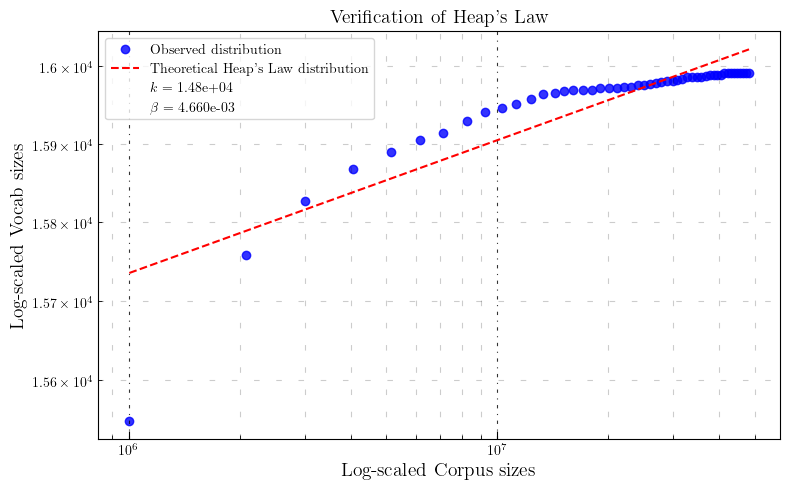

In [ ]:
plot_heaps_law(vocab_sizes_list[:50], corpus_sizes_list[:50])

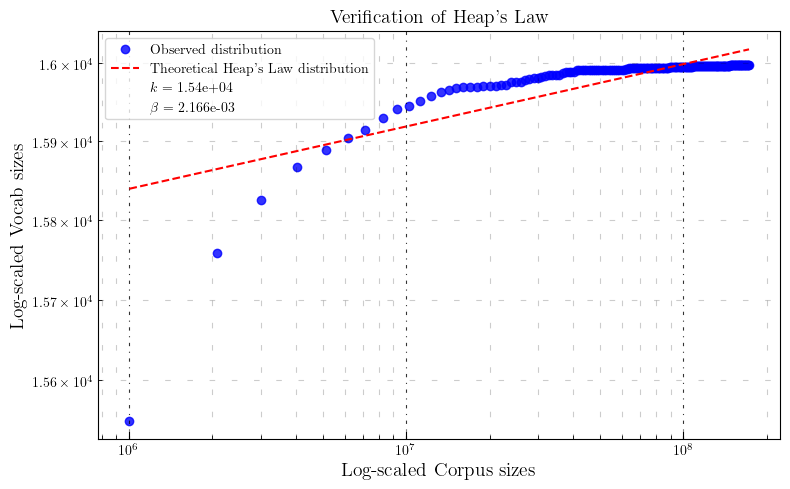

In [ ]:
plot_heaps_law(vocab_sizes_list, corpus_sizes_list)  # heaps law for all documents